In [60]:
import pandas as pd
import re
import sklearn
import seaborn as sns
import logging 
import numpy as np 
from optparse import OptionParser
import sys
from time import time 
import matplotlib.pyplot as plt 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import HashingVectorizer 
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron 
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from nltk.corpus import stopwords 
import nltk

In [119]:
stopwords = stopwords.words('english')

In [123]:
wnl = nltk.WordNetLemmatizer()

In [27]:
news_data = pd.read_excel('labeled_data_11_29.xlsx')
news_data.head()

,Unnamed: 0,Year,Headlines,Time,Tokens,pos_tag,senti_score,Overall Sentiment
0,0,2020-01-01,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","['better', 'way', 'invest', 'vaccine', 'gold',...","[('better', 'RBR'), ('way', 'NN'), ('invest', ...",0.875,Positive
1,1,2020-01-01,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","['would', 'teradyne']","[('would', 'MD'), ('teradyne', 'VB')]",0.000,Neutral
2,2,2020-01-01,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","['big', 'week', 'earnings', 'even', 'bigger', ...","[('big', 'JJ'), ('week', 'NN'), ('earnings', '...",0.375,Positive
3,3,2020-01-01,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","['capital', 'keith', 'bliss', 'tech', 'healthc...","[('capital', 'NN'), ('keith', 'NN'), ('bliss',...",0.250,Positive
4,4,2020-01-01,Wall Street delivered the 'kind of pullback I'...,"7:36 PM ET Thu, 16 July 2020","['street', 'delivered', 'kind', 'pullback', 'w...","[('street', 'NN'), ('delivered', 'VBD'), ('kin...",0.000,Neutral


In [33]:
data = news_data.copy()

C:\Anaconda\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Overall Sentiment', ylabel='count'>

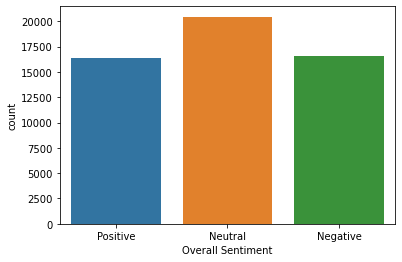

In [34]:
sns.countplot(data['Overall Sentiment'])

In [35]:
data['Label'] = data['Overall Sentiment'].replace({'Positive':1, 'Neutral':0, 'Negative':-1})

In [91]:
data['Tokens'] = data['Tokens'].apply(lambda x : re.sub(r'[\[\]\']','',x))

In [94]:
data['sentence'] = data['Tokens'].apply(lambda x : x.split(','))

In [96]:
data['sentence'] = data['sentence'].apply(lambda x:''.join(x))

In [107]:
data = data.drop(['Unnamed: 0'], axis = 1)

In [111]:
for i in range(len(data.sentence)):
    if len(data.sentence[i]) == 0:
        data.sentence[i] = data.Headlines[i]

<ipython-input-111-75666307fcaa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sentence[i] = data.Headlines[i]


In [116]:
data['Tokens'] = [nltk.word_tokenize(sent) 
                        for sent in data.sentence]

In [121]:
def normal_tokenized(tokens) -> list:
    Tokens = []
    for token in tokens:
        Tokens.append([wnl.lemmatize(word).lower()
                                           for word in token 
                                           if word.lower() not in stopwords and
                                           word.isalpha()]) 
    return Tokens

In [129]:
data['Tokens'] = normal_tokenized(data['Tokens'])

In [130]:
data['sentence'] = data['Tokens'].apply(lambda x:' '.join(x))

In [162]:
data.to_excel('ready_to_model.xlsx')

In [137]:
train_data = data.copy()

In [18]:
train_data = pd.read_excel('ready_to_model.xlsx')

In [4]:
train_data.head()

,Unnamed: 0,Year,Headlines,Time,Tokens,pos_tag,senti_score,Overall Sentiment,Label,sentence
0,0,2020-01-01,Jim Cramer: A better way to invest in the Covi...,"7:51 PM ET Fri, 17 July 2020","['better', 'way', 'invest', 'vaccine', 'gold',...","[('better', 'RBR'), ('way', 'NN'), ('invest', ...",0.875,Positive,1,better way invest vaccine gold rush
1,1,2020-01-01,Cramer's lightning round: I would own Teradyne,"7:33 PM ET Fri, 17 July 2020","['would', 'teradyne']","[('would', 'MD'), ('teradyne', 'VB')]",0.000,Neutral,0,would teradyne
2,2,2020-01-01,"Cramer's week ahead: Big week for earnings, ev...","7:25 PM ET Fri, 17 July 2020","['big', 'week', 'earnings', 'even', 'bigger', ...","[('big', 'JJ'), ('week', 'NN'), ('earnings', '...",0.375,Positive,1,big week earnings even bigger week vaccine
3,3,2020-01-01,IQ Capital CEO Keith Bliss says tech and healt...,"4:24 PM ET Fri, 17 July 2020","['capital', 'keith', 'bliss', 'tech', 'healthc...","[('capital', 'NN'), ('keith', 'NN'), ('bliss',...",0.250,Positive,1,capital keith bliss tech healthcare rally
4,4,2020-01-01,Wall Street delivered the 'kind of pullback I'...,"7:36 PM ET Thu, 16 July 2020","['street', 'delivered', 'kind', 'pullback', 'w...","[('street', 'NN'), ('delivered', 'VBD'), ('kin...",0.000,Neutral,0,street delivered kind pullback waiting


In [19]:
features = train_data.iloc[:,9]
label = train_data.iloc[:,8]

In [74]:
features

0                      better way invest vaccine gold rush
1                                           would teradyne
2               big week earnings even bigger week vaccine
3                capital keith bliss tech healthcare rally
4                   street delivered kind pullback waiting
                               ...                        
53365        never hired british data firm center scrutiny
53366    search volkswagen headquarters new emission in...
53367                  set greenhouse gas reduction target
53368    pratt whitney deliver spare engine soon india ...
53369    uk always consider way improve data law pm may...
Name: sentence, Length: 53370, dtype: object

## Bag of Words

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
bow_counts = CountVectorizer(tokenizer= nltk.word_tokenize, 
                             ngram_range=(1,3))

bow_data = bow_counts.fit_transform(features)

In [78]:
from sklearn.model_selection import train_test_split
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, label,test_size = 0.2, random_state = 123)

### Logistic Regression--Bag of Words

In [83]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression() 
lr_model.fit(X_train_bow, y_train_bow) 

test_pred = lr_model.predict(X_test_bow) # Class prediction


from sklearn.metrics import classification_report
print(classification_report(y_test_bow,test_pred))

              precision    recall  f1-score   support

          -1       0.86      0.79      0.82      3306
           0       0.75      0.90      0.82      4037
           1       0.87      0.74      0.80      3331

    accuracy                           0.81     10674
   macro avg       0.83      0.81      0.81     10674
weighted avg       0.82      0.81      0.81     10674



C:\Anaconda\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
test_prob = lr_model.predict_proba(X_test_bow)

In [84]:
accuracy = accuracy_score(y_test_bow,test_pred)
accuracy

0.8139404159640248

### SVM---Bag of Words

In [28]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import classification_report

In [10]:
scaler = StandardScaler(with_mean=False)
X_train_bow_scaled = scaler.fit_transform(X_train_bow.astype(np.float64))

In [5]:
# # 训练多分类模型
from sklearn.svm import SVC
# svm_clf = LinearSVR(kernel='sigmoid',random_state=123,
#               max_iter=5000, decision_function_shape='ovr')
# svm_clf.fit(X_train_bow_scaled, y_train_bow)
# ovr_clf = OneVsRestClassifier(svm.SVC(kernel='linear',probability=True,random_state=123))
# svm = ovr_clf.fit(X_train_bow,y_train_bow)
# # joblib.dump(clt,"F:/python/model/conv_19_80%.pkl")
# test_pred = svm_clf.predict(X_test_bow)
# print(classification_report(y_test_bow,test_pred))


In [42]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

clf = make_pipeline(StandardScaler(with_mean=False),
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train_bow, y_train_bow)

In [29]:
test_pred = clf.predict(X_test_bow)
print(classification_report(y_test_bow,test_pred))

              precision    recall  f1-score   support

          -1       0.70      0.61      0.65      3306
           0       0.59      0.79      0.68      4037
           1       0.72      0.54      0.61      3331

    accuracy                           0.65     10674
   macro avg       0.67      0.64      0.65     10674
weighted avg       0.67      0.65      0.65     10674



### SGDclassifier-Bag of Words

In [49]:
from sklearn.linear_model import SGDClassifier

In [ ]:
# clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)# (soft-margin) linear Support Vector Machine
# loss="modified_huber": smoothed hinge loss
# loss="log": logistic regression
# loss="log" and loss="modified_huber" are more suitable for one-vs-all classification.

In [54]:
clf = make_pipeline(StandardScaler(with_mean=False),
                    SGDClassifier(loss="log",shuffle=True,penalty="l2"))
clf.fit(X_train_bow, y_train_bow)


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier', SGDClassifier(loss='log'))])

In [55]:
test_pred = clf.predict(X_test_bow)
print(classification_report(y_test_bow,test_pred))

              precision    recall  f1-score   support

          -1       0.64      0.63      0.63      3306
           0       0.63      0.65      0.64      4037
           1       0.64      0.62      0.63      3331

    accuracy                           0.63     10674
   macro avg       0.63      0.63      0.63     10674
weighted avg       0.63      0.63      0.63     10674



## TF-IDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
noise_words = []
tfidf_counts = TfidfVectorizer(tokenizer= nltk.word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(features)

In [33]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data, label,test_size = 0.2, random_state = 123)

In [109]:
new_tfidf_data = tfidf_counts.transform(pd.Series(news1))

### Logistic Regression_TF-IDF

In [80]:
from sklearn.metrics import accuracy_score

In [43]:
### Setting up the model class
lr_model_tf_idf = LogisticRegression()

## Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
train_pred_lr_all = lr_model_tf_idf.predict(X_train_tfidf)

test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Calculate key performance metrics


# Print a classification report
print(classification_report(y_test_tfidf,test_pred_lr_all))

              precision    recall  f1-score   support

          -1       0.86      0.80      0.83      3306
           0       0.76      0.89      0.82      4037
           1       0.87      0.75      0.81      3331

    accuracy                           0.82     10674
   macro avg       0.83      0.81      0.82     10674
weighted avg       0.83      0.82      0.82     10674



C:\Anaconda\envs\py38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [82]:
accuracy = accuracy_score(y_test_tfidf,test_pred_lr_all)
accuracy

0.8196552370245457

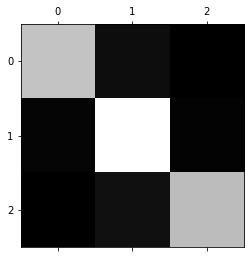

In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
conf_mx = confusion_matrix(y_train_tfidf,train_pred_lr_all)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [47]:
row_nums = conf_mx.sum(axis = 1, keepdims = True) 
norm_conf_mx = conf_mx / row_nums

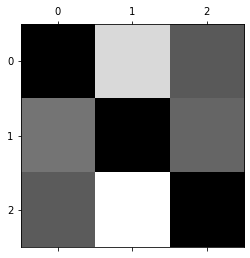

In [48]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

### SVM_TF-IDF

In [35]:
clf_tf = make_pipeline(StandardScaler(with_mean=False),
                    LinearSVC(random_state=0, tol=1e-5))
clf_tf.fit(X_train_tfidf, y_train_tfidf)

C:\Anaconda\envs\py38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [98]:
clf_tf

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [36]:
test_pred_tf = clf_tf.predict(X_test_tfidf)

In [110]:
test_pred_tf_new = clf_tf.predict(new_tfidf_data)
test_pred_tf_new

array([1], dtype=int64)

In [103]:
test_pred_tf_new

array([1], dtype=int64)

In [38]:
print(classification_report(y_test_tfidf,test_pred_tf))

              precision    recall  f1-score   support

          -1       0.81      0.75      0.78      3306
           0       0.71      0.79      0.75      4037
           1       0.80      0.74      0.77      3331

    accuracy                           0.76     10674
   macro avg       0.77      0.76      0.76     10674
weighted avg       0.77      0.76      0.76     10674



### More Powerful Way to Train the text Classifer learned from sklearn doc

#### Pre Setting

In [64]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

op = OptionParser() 
op.add_option(
    "--report",
    action="store_true",
    dest="print_report",
    help="Print a detailed classification report.",
)
op.add_option(
    "--chi2_select",
    action="store",
    type="int",
    dest="select_chi2",
    help="Select some number of features using a chi-squared test",
)
op.add_option(
    "--confusion_matrix",
    action="store_true",
    dest="print_cm",
    help="Print the confusion matrix.",
)
op.add_option(
    "--top10",
    action="store_true",
    dest="print_top10",
    help="Print ten most discriminative terms per class for every classifier.",
)
op.add_option(
    "--all_categories",
    action="store_true",
    dest="all_categories",
    help="Whether to use all categories or not.",
)
op.add_option("--use_hashing", action="store_true", help="Use a hashing vectorizer.")
op.add_option(
    "--n_features",
    action="store",
    type=int,
    default=2 ** 16,
    help="n_features when using the hashing vectorizer.",
)
op.add_option(
    "--filtered",
    action="store_true",
    help=(
        "Remove newsgroup information that is easily overfit: "
        "headers, signatures, and quoting."
    ),
)


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



#### Run with TF-IDF

In [79]:
def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_tfidf, y_train_tfidf)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_tfidf)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test_tfidf, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, "coef_"):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test_tfidf, pred, target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test_tfidf, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=3), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


C:\Anaconda\envs\py38\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 0.976s
test time:  0.010s
accuracy:   0.817
dimensionality: 18515
density: 0.918769


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.257s
test time:  0.001s
accuracy:   0.798
dimensionality: 18515
density: 0.649707


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.664s
test time:  0.001s
accuracy:   0.819
dimensionality: 18515
density: 0.822000


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.005s
test time:  15.397s
accuracy:   0.537

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 225.228s
test time:  2.233s
accuracy:   0.844

L2 penalty
____________________________________

C:\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
C:\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
C:\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 1.788s
test time:  0.013s
accuracy:   0.848



#### Visulazation Performance

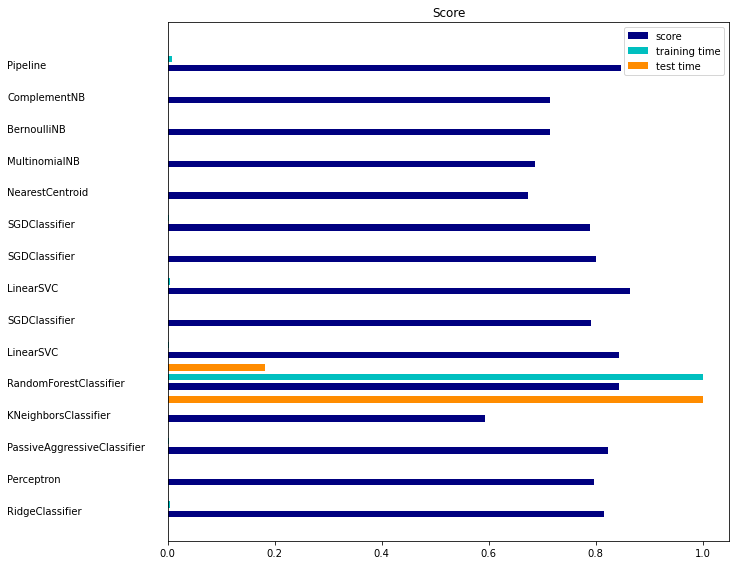

In [66]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()

#### Run with Bag of Words

In [86]:
def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_bow,  y_train_bow)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_bow)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test_bow, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, "coef_"):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test_bow, pred, target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test_bow, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=3), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


C:\Anaconda\envs\py38\lib\site-packages\sklearn\linear_model\_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 4.176s
test time:  0.011s
accuracy:   0.815
dimensionality: 449359
density: 0.820627


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.470s
test time:  0.009s
accuracy:   0.826
dimensionality: 449359
density: 0.312926


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.459s
test time:  0.009s
accuracy:   0.834
dimensionality: 449359
density: 0.642972


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=3)
train time: 0.005s
test time:  11.207s
accuracy:   0.440

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 2778.547s
test time:  4.559s
accuracy:   0.819

L2 penalty
________________________________

C:\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
C:\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.062s
test time:  0.050s
accuracy:   0.644
dimensionality: 449359
density: 1.000000


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.057s
test time:  0.009s
accuracy:   0.664
dimensionality: 449359
density: 1.000000


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])


C:\Anaconda\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 6.848s
test time:  0.025s
accuracy:   0.870

